In [8]:
import pandas as pd
import numpy as np
import torchaudio
from pathlib import Path
from fastai.vision.all import *
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from sklearn.model_selection import StratifiedKFold, GroupKFold
import librosa
import soundfile as sf

In [3]:
SEED = 42
DATA_PATH = Path("./birdclef-2022/")
AUDIO_PATH = Path("./birdclef-2022/train_audio")

NUM_WORKERS = 4
CLASSES = sorted(os.listdir(AUDIO_PATH))
NUM_CLASSES = len(CLASSES)
class AudioParams:
    # audio data
    sr = 32000
    duration = 5

    # Melspectrogram
    n_mels = 224
    fmin = 20
    fmax = 16000


train = pd.read_csv(DATA_PATH / 'train_metadata.csv')
train["file_path"] = AUDIO_PATH / train['filename']
paths = train["file_path"].values

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_index, val_index) in enumerate(Fold.split(train, train['primary_label'])):
    train.loc[val_index, 'kfold'] = int(n)
train['kfold'] = train['kfold'].astype(int)

train.to_csv('train_folds.csv', index=False)

print(train.shape)
train.head()

(14852, 15)


/home/kilian/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path,kfold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,birdclef-2022/train_audio/afrsil1/XC125458.ogg,0
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,birdclef-2022/train_audio/afrsil1/XC175522.ogg,0
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,birdclef-2022/train_audio/afrsil1/XC177993.ogg,1
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,birdclef-2022/train_audio/afrsil1/XC205893.ogg,4
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,birdclef-2022/train_audio/afrsil1/XC207431.ogg,4


In [6]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec


def crop_or_pad(y, length, sr, train=True, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if not train:
            start = 0
        elif probs is None:
            start = np.random.randint(len(y) - length)
        else:
            start = (
                    np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start: start + length]

    return y.astype(np.float32)


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

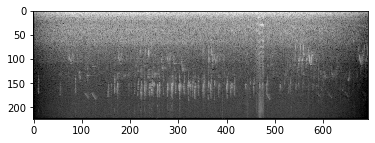

In [9]:
# original

path = train['file_path'][0]
y, sr = sf.read(path, always_2d=True)
y = np.mean(y, 1)

X = compute_melspec(y, AudioParams)
X = mono_to_color(X)
X = X.astype(np.uint8)

plt.imshow(X)

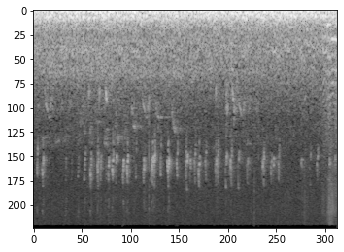

In [10]:
# 5 sec cropped

path = train['file_path'][0]
y, sr = sf.read(path, always_2d=True)
y = np.mean(y, 1)
y = crop_or_pad(y, AudioParams.duration * AudioParams.sr, sr=AudioParams.sr, train=True, probs=None)

X = compute_melspec(y, AudioParams)
X = mono_to_color(X)
X = X.astype(np.uint8)

plt.imshow(X)

In [29]:
def Audio_to_Image(path, params):
    y, sr = sf.read(path, always_2d=True)
    y = np.mean(y, 1) # there is (X, 2) array
    y = crop_or_pad(y, params.duration * params.sr, sr=params.sr, train=True, probs=None)
    image = compute_melspec(y, params)
    image = mono_to_color(image)
    image = image.astype(np.uint8)
    return image

def save_(path):
    save_path = DATA_PATH / "spectograms" / path.parts[2] / path.stem
    print(save_path)
    np.save(save_path, Audio_to_Image(path, AudioParams))

In [30]:
NUM_WORKERS = 4
for dir_ in CLASSES:
    dir_path = DATA_PATH / "spectograms" / dir_
    _ = os.makedirs(dir_path, exist_ok=True)
_ = Parallel(n_jobs=NUM_WORKERS)(delayed(save_)(AUDIO_PATH) for AUDIO_PATH in tqdm(paths))

  0%|          | 0/14852 [00:00<?, ?it/s]